In [0]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
rate_data_rub = pd.read_csv('data_bond_zero_curve_30_years.csv', sep=';')
rate_data_rub.head()

,Date,0.25,0.5,0.75,1,2,3,5,7,10,15,20,30
0,2016-01-04,8.77,9.34,9.70,9.91,10.07,9.97,9.80,9.67,9.51,9.39,9.35,9.34
1,2016-01-05,8.63,9.23,9.60,9.81,10.00,9.92,9.74,9.61,9.50,9.42,9.40,9.39
2,2016-01-06,8.65,9.24,9.61,9.84,10.09,10.02,9.85,9.74,9.61,9.50,9.46,9.44
3,2016-01-11,9.67,10.29,10.55,10.64,10.52,10.42,10.35,10.26,10.06,9.95,9.93,9.92
4,2016-01-12,9.70,10.33,10.62,10.74,10.65,10.54,10.46,10.39,10.24,10.14,10.11,10.10


In [0]:
rate_data_usd = pd.read_csv('libor_usd.csv', sep=';').iloc[::-1].reset_index()
rate_data_usd.head()

,index,Date,ON,1W,1M,2M,3M,6M,12M
0,1008,2016-01-04,0.3658,0.38750,0.4225,0.51040,0.61170,0.84225,1.16925
1,1007,2016-01-05,0.3650,0.38625,0.4220,0.51480,0.61710,0.85120,1.17310
2,1006,2016-01-06,0.3661,0.38715,0.4235,0.51660,0.62010,0.85130,1.16535
3,1005,2016-01-07,0.3651,0.38470,0.4235,0.51115,0.61685,0.84480,1.14710
4,1004,2016-01-08,0.3662,0.38485,0.4238,0.51495,0.62110,0.85080,1.15510


In [0]:
RUB_rate = rate_data_rub['0.25'].iloc[500:]
RUB_rate.count()
df_rub = pd.DataFrame(data=RUB_rate)
df_rub.head()

,0.25
500,6.49
501,6.18
502,6.46
503,6.16
504,5.79


In [0]:
USD_rate = rate_data_usd['3M'].iloc[500:]
USD_rate.count()
df_usd = pd.DataFrame(data=USD_rate)
df_usd.head()

,3M
500,1.69339
501,1.69465
502,1.69428
503,1.69693
504,1.69593


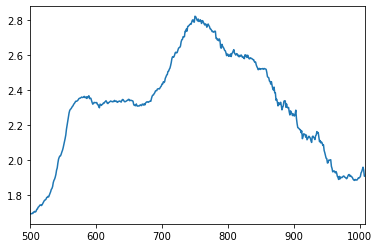

In [0]:
USD_rate.plot()

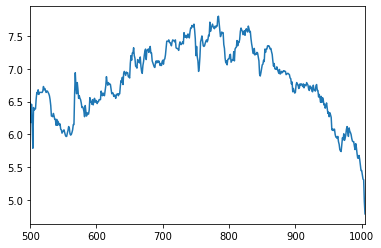

In [0]:
RUB_rate.plot()

In [0]:
values_rub = RUB_rate.div(100).values
values_usd = USD_rate.div(100).values
def vasicek(values):
  delta_t = 1 / 365
  n = values.shape[0]
  X = values[:-1]
  Y = values[1:]
  Sx = X.sum()
  Sy = Y.sum()
  Sxx = np.sum(X**2)
  Sxy = np.sum(X*Y)
  Syy = np.sum(Y**2)
  
  mu = (Sy*Sxx - Sx*Sxy) / ( n*(Sxx - Sxy) - (Sx**2 - Sx*Sy) )
  lambda_ = ( (Sxy - mu*Sx - mu*Sy + n*mu**2) / (Sxx -2*mu*Sx + n*mu**2) ) / delta_t; 
  a = 1-lambda_*delta_t;
  sigmah2 = (Syy - 2*a*Sxy + a**2*Sxx - 2*mu*(1-a)*(Sy - a*Sx) + n*mu**2*(1-a)**2)/n; 
  sigma = (sigmah2*2*lambda_/(1-a**2))**1/2
  return mu, lambda_, sigma

In [0]:
vasicek(values_usd)

(0.02451863542164462, 363.91752595960406, 0.0041566433154676735)

In [0]:
vasicek(values_rub)

(0.09548374194906355, 365.44778898025885, 0.2897037444178343)

Сгенерируем ставки процента, полученные по модели Васичека через GBM:

In [0]:
def simulate_ir_paths(mu: float, sigma: float, s0: float, lambd: float, n_sim: int, n_steps: int):
    simulations = np.empty((n_sim, n_steps+1))
    simulations[:, 0] = s0
    dt = 1. / 365
    
    for sim_idx in range(n_sim):
        for step_idx in range(1, n_steps+1):
            prev_value = simulations[sim_idx, step_idx-1]
            drift_coef = lambd * (mu - prev_value) * dt
            randomness = np.random.normal() * np.sqrt(dt) * sigma
            simulations[sim_idx, step_idx] = prev_value + drift_coef + randomness
    return simulations

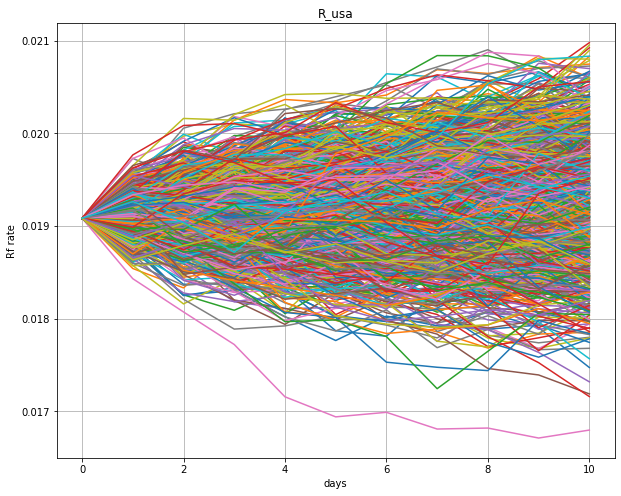

In [0]:
sims = simulate_ir_paths(0.02451863542164462, 0.0041566433154676735, values_usd[-1], 1, 1000, 10)
plt.figure(figsize=(10, 8))
plt.title('R_usa')
plt.xlabel('days')
plt.grid()
plt.ylabel('Rf rate')
for i in range(sims.shape[0]):
    plt.plot(range(0, 11), sims[i])
plt.show()

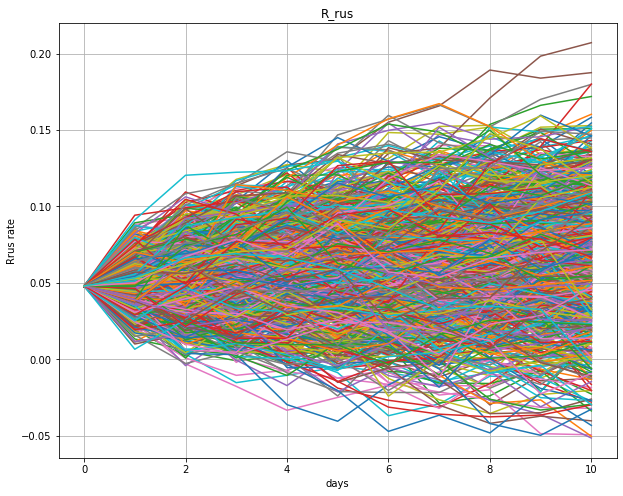

In [0]:
sims = simulate_ir_paths(0.09548374194906355, 0.2897037444178343, values_rub[-1], 20, 1000, 10)
plt.figure(figsize=(10, 8))
plt.title('R_rus')
plt.xlabel('days')
plt.grid()
plt.ylabel('Rrus rate')
for i in range(sims.shape[0]):
    plt.plot(range(0, 11), sims[i])
plt.show()